In [1]:
from run import Prepro
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [2]:
train_test_split = 0.8 #how much train test data
predict_at = 8 #steps_out
window_size = 8 #how many timesteps from the past to take ie steps_in

#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
#vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)
#vision_data = np.load('data/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)
#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('data/y_50_20_60_3years_v2.npy', allow_pickle = True) 
#y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True) 
#y = np.load('data/y_50_20_90_1980_v3.npy', allow_pickle = True) 
train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = predict_at, window_size =  window_size)
x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 10])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
target_intensity_cat torch.Size([3735])
target_intensity_cat_baseline torch.Size([3735])
Keeping 3143 samples out of the initial 3735.
Reshaping the displacement target...


In [4]:
x_stat_train[0,1,:]
#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR', 


#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
#'STORM_SPEED', 'STORM_DIR', 'storm_category', 'basin_EP', 'basin_NI',
#'basin_SI', 'basin_SP', 'basin_WP', 'nature_DS', 'nature_ET',
#'nature_MX', 'nature_NR', 'nature_SS', 'nature_TS'
#'STORM CATEGORY', 
#'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y'

tensor([ 3.5125e+00, -1.7131e+02,  3.0000e+01,  1.0040e+03,  1.9080e+03,
         3.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1250e-01,
        -7.0000e-03])

In [3]:
def prepare_fresh(X):
    data = np.array(X)
    n, t, p = X.shape
    new_data = np.zeros((n, t, p+2))
    for i in range(n):
        for j in range(t):
            new_data[i,j,2:] = data[i,j]
            new_data[i,j,0] = int(i)
            new_data[i,j,1] = int(j)
    new_data = new_data.reshape(n*t, -1)
    new_data = pd.DataFrame(new_data).rename(columns={0: "storm_id", 1: "time"})
    new_data = new_data.astype({"storm_id": 'int32', "time": 'int32'})
    for i in range(p+2):
        new_data = new_data.rename(columns={i:"feat_"+str(i-1)})
    return new_data

In [21]:
a = prepare_fresh(np.concatenate((x_stat_train, x_stat_test), axis = 0))

In [6]:
df_features = extract_features(a, column_id="storm_id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


In [25]:
features_filtered_direct = extract_relevant_features(a, pd.Series(np.concatenate((tgt_intensity_cat_train, tgt_intensity_cat_test), axis = 0)), column_id='storm_id', column_sort='time')

Feature Extraction: 100%|██████████| 20/20 [05:59<00:00, 17.98s/it]


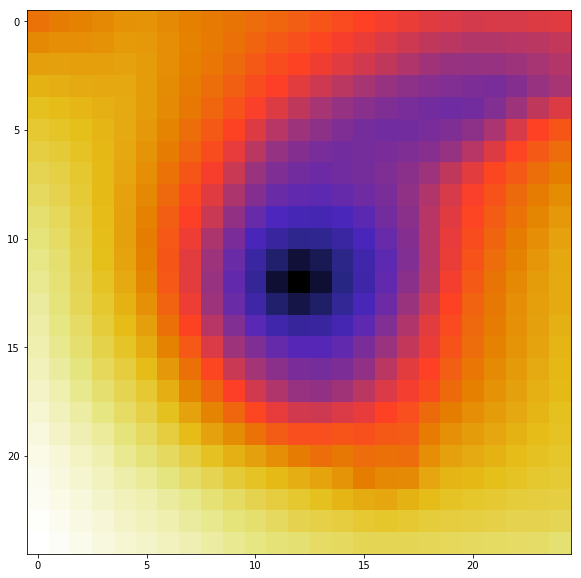

In [49]:
plt.figure(figsize = (10,10))
plt.imshow(x_viz_train[70,7,6], cmap = 'CMRmap') #CMRmap

In [29]:
x_viz_train.shape
#samples * timesteps * number of maps * size of map * size of map

torch.Size([628, 8, 9, 25, 25])

In [30]:
x_stat_train.shape
#samples * number of past timesteps * number of features

torch.Size([628, 8, 10])

In [5]:
X_train = x_stat_train.reshape(-1, window_size*x_stat_train.shape[2])
X_test = x_stat_test.reshape(-1,window_size*x_stat_train.shape[2])

X_train_vision = x_viz_train.reshape(x_viz_train.shape[0], -1)
X_test_vision = x_viz_test.reshape(x_viz_test.shape[0], -1)

X_train_tab_vision = np.concatenate((X_train, X_train_vision), axis = 1)
X_test_tab_vision = np.concatenate((X_test, X_test_vision), axis = 1)

In [20]:
np.save('data/X_train_stat_1980_50_20_90.npy', X_train, allow_pickle = True)
np.save('data/X_test_stat_1980_50_20_90.npy', X_test, allow_pickle = True)

np.save('data/X_train_vision_1980_50_20_90.npy', X_train_vision, allow_pickle = True)
np.save('data/X_test_vision_1980_50_20_90.npy', X_test_vision, allow_pickle = True)

np.save('data/y_train_intensity_1980_50_20_90.npy', tgt_intensity_cat_train, allow_pickle = True)
np.save('data/y_test_intensity_1980_50_20_90.npy', tgt_intensity_cat_test, allow_pickle = True)

np.save('data/y_train_displacement_1980_50_20_90.npy', tgt_displacement_train, allow_pickle = True)
np.save('data/y_test_displacement_1980_50_20_90.npy', tgt_displacement_test, allow_pickle = True)

OSError: 511290000 requested and 421057536 written

In [2]:
window_size = 8
'data/X_train_stat_1980_50_20_90_w' + str(window_size) + '.npy'

'data/X_train_stat_1980_50_20_90_w12.npy'

In [ ]:
X_train = np.load('data/X_train_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)
X_test = np.load('data/X_test_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

X_train_vision = np.load('data/X_train_vision_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
X_test_vision = np.load('data/X_test_vision_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

tgt_intensity_cat_train = np.load('data/y_train_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_intensity_cat_test = np.load('data/y_test_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

tgt_intensity_cat_baseline_train = np.load('data/y_train_intensity_cat_baseline_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_intensity_cat_baseline_test = np.load('data/y_test_intensity_cat_baseline_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

tgt_displacement_train = np.load('data/y_train_displacement_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_displacement_test = np.load('data/y_test_displacement_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

In [11]:
X = np.load('data/X_train_1980_50_20_90.npy', allow_pickle = True)

In [56]:
xgb = XGBClassifier(max_depth=6, n_estimators=100)
xgb.fit(features_filtered_direct[:1984], tgt_intensity_cat_train)
yhat = xgb.predict(features_filtered_direct[1984:])
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.5090543259557344
Baseline score 0.4949698189134809


In [59]:
xgb = XGBClassifier(max_depth=8, n_estimators=100)
xgb.fit(np.concatenate((features_filtered_direct[:1984], X_train), axis = 1), tgt_intensity_cat_train)
yhat = xgb.predict(np.concatenate((features_filtered_direct[1984:], X_test), axis = 1))
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.545271629778672
Baseline score 0.4949698189134809


In [6]:
xgb = XGBClassifier(max_depth=5, n_estimators=80)
xgb.fit(X_train, tgt_intensity_cat_train)
yhat = xgb.predict(X_test)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.5230524642289348
Baseline score 0.45151033386327505


In [24]:
xgb = XGBClassifier(max_depth=6, n_estimators=100)
xgb.fit(X_train_tab_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_tab_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

KeyboardInterrupt: 

In [66]:
xgb = XGBClassifier(max_depth=6, n_estimators=100)
xgb.fit(X_train_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.3762575452716298
Baseline score 0.4949698189134809


In [7]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, tgt_intensity_cat_train)
yhat = rf.predict(X_test)
print("RF score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

RF score 0.845625770110896
Baseline score 0.8804787889456082


In [32]:
xgb_x = XGBRegressor(max_depth=5, n_estimators=100)
xgb_y = XGBRegressor(max_depth=5, n_estimators=100)
xgb_x.fit(X_train, tgt_displacement_train[:,0])
xgb_y.fit(X_train, tgt_displacement_train[:,1])

yhat_x = xgb_x.predict(X_test)
yhat_y = xgb_y.predict(X_test)
print("XGB x score", mean_absolute_error(tgt_displacement_test[:,0], yhat_x))
print("XGB y score", mean_absolute_error(tgt_displacement_test[:,1], yhat_y))
#be careful for interpretation because the displacement is in degree + standardized + I did not code any baseline

[18:04:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB x score 0.8286559
XGB y score 1.2342972


In [15]:
xgb_intensity = XGBRegressor(max_depth=5, n_estimators=100)
xgb_intensity.fit(X_train, tgt_intensity_train)

yhat_intensity = xgb_intensity.predict(X_test)
print("XGB x score", mean_absolute_error(tgt_intensity_test, yhat_intensity))

[13:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB x score 12.20803


In [19]:
tgt_intensity_test

tensor([ 0.7458,  0.8419,  0.9379,  ..., -0.5869, -0.5909, -0.5949])

In [69]:
tgt_displacement_train.max()

tensor(4.7578)

In [74]:
def prepare_fresh_2(X):
    data = X.reshape(X.shape[0], window_size, X.shape[1]//window_size)
    n, t, p = data.shape
    new_data = np.zeros((n, t, p+2))
    for i in range(n):
        for j in range(t):
            new_data[i,j,2:] = data[i,j]
            new_data[i,j,0] = int(i)
            new_data[i,j,1] = int(j)
    new_data = new_data.reshape(n*t, -1)
    new_data = pd.DataFrame(new_data).rename(columns={0: "storm_id", 1: "time"})
    new_data = new_data.astype({"storm_id": 'int32', "time": 'int32'})
    for i in range(p+2):
        new_data = new_data.rename(columns={i:"feat_"+str(i-1)})
    return new_data

tensor(1.0000)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

window_size = 8

X_train = np.load('data/X_train_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)
X_test = np.load('data/X_test_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

X_train_vision = np.load('data/X_train_vision_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
X_test_vision = np.load('data/X_test_vision_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

tgt_intensity_cat_train = np.load('data/y_train_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_intensity_cat_test = np.load('data/y_test_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

tgt_intensity_cat_baseline_train = np.load('data/y_train_intensity_cat_baseline_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_intensity_cat_baseline_test = np.load('data/y_test_intensity_cat_baseline_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

tgt_displacement_train = np.load('data/y_train_displacement_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_displacement_test = np.load('data/y_test_displacement_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

def prepare_fresh_2(X):
    data = X.reshape(X.shape[0], window_size, X.shape[1]//window_size)
    n, t, p = data.shape
    new_data = np.zeros((n, t, p+2))
    for i in range(n):
        for j in range(t):
            new_data[i,j,2:] = data[i,j]
            new_data[i,j,0] = int(i)
            new_data[i,j,1] = int(j)
    new_data = new_data.reshape(n*t, -1)
    new_data = pd.DataFrame(new_data).rename(columns={0: "storm_id", 1: "time"})
    new_data = new_data.astype({"storm_id": 'int32', "time": 'int32'})
    for i in range(p+2):
        new_data = new_data.rename(columns={i:"feat_"+str(i-1)})
    return new_data

a = prepare_fresh_2(np.concatenate((X_train, X_test), axis = 0))
features_filtered_direct = extract_relevant_features(a, pd.Series(np.concatenate((tgt_intensity_cat_train, tgt_intensity_cat_test), axis = 0)), column_id='storm_id', column_sort='time')

FileNotFoundError: [Errno 2] No such file or directory: 'data/X_train_stat_1980_50_20_90_w8.npy'

In [ ]:
grid_scenarios3 = iai.GridSearch(
        iai.OptimalTreeClassifier(
            random_seed=1,
            criterion = 'misclassification'
        ),
        max_depth=range(3, 4),
    )

grid_scenarios3.fit(X_train2, tgt_intensity_cat_train)
lnr_scenarios3 = grid_scenarios3.get_learner()
print(grid_scenarios3.get_grid_results())

print("Classification based scenarios, Accuracy: ", lnr_scenarios3.score(X_test, tgt_intensity_cat_test, criterion='misclassification'))


In [28]:
names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'STORM_DIR', 'storm_category', 'cat_basin_EP', 'cat_basin_NI',
'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
'cat_UNKNOWN', 
'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']
names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i//22)

    
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

cols = [c for c in X_train2.columns if c.lower()[-1] == '0' or c.lower()[:3] != 'cat']

X_train = X_train[cols]
X_test = X_test[cols]

In [29]:
#for tsfresh
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tsfresh import extract_features
from tsfresh import extract_relevant_features

window_size = 16

X_train = np.load('data/X_train_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)
X_test = np.load('data/X_test_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

tgt_intensity_train = np.load('data/y_train_intensity_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
tgt_intensity_test = np.load('data/y_test_intensity_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)

def prepare_fresh(X):
    data = X.reshape(X.shape[0], window_size, X.shape[1]//window_size)
    n, t, p = data.shape
    new_data = np.zeros((n, t, p+2))
    for i in range(n):
        for j in range(t):
            new_data[i,j,2:] = data[i,j]
            new_data[i,j,0] = int(i)
            new_data[i,j,1] = int(j)
    new_data = new_data.reshape(n*t, -1)
    new_data = pd.DataFrame(new_data).rename(columns={0: "storm_id", 1: "time"})
    new_data = new_data.astype({"storm_id": 'int32', "time": 'int32'})
    for i in range(p+2):
        new_data = new_data.rename(columns={i:"feat_"+str(i-1)})
    return new_data

names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'STORM_DIR', 'storm_category', 'cat_basin_EP', 'cat_basin_NI',
'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
'cat_UNKNOWN', 
'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i//22)

    
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

cols = [c for c in X_train.columns if c.lower()[:3] != 'cat']

X_train = np.array(X_train[cols])
X_test = np.array(X_test[cols])

a = prepare_fresh(np.concatenate((X_train, X_test), axis = 0))
features_filtered_direct = extract_relevant_features(a, pd.Series(np.concatenate((tgt_intensity_train, tgt_intensity_test), axis = 0)), column_id='storm_id', column_sort='time')
X
np.save('data/test_features_filtered_direct_w' + str(window_size) +'.npy', np.array(features_filtered_direct), allow_pickle = True)

['LAT_0',
 'LON_0',
 'WMO_WIND_0',
 'WMO_PRES_0',
 'DIST2LAND_0',
 'STORM_SPEED_0',
 'STORM_DIR_0',
 'storm_category_0',
 'basin_EP_0',
 'cat_basin_NI_0',
 'cat_basin_SI_0',
 'cat_basin_SP_0',
 'cat_basin_WP_0',
 'cat_nature_DS_0',
 'cat_nature_ET_0',
 'cat_nature_MX_0',
 'cat_nature_NR_0',
 'cat_nature_SS_0',
 'cat_nature_TS_0',
 'STORM CATEGORY_0',
 'STORM_DISPLACEMENT_X_0',
 'STORM_DISPLACEMENT_Y_0',
 'LAT_1',
 'LON_1',
 'WMO_WIND_1',
 'WMO_PRES_1',
 'DIST2LAND_1',
 'STORM_SPEED_1',
 'STORM_DIR_1',
 'storm_category_1',
 'basin_EP_1',
 'STORM CATEGORY_1',
 'STORM_DISPLACEMENT_X_1',
 'STORM_DISPLACEMENT_Y_1',
 'LAT_2',
 'LON_2',
 'WMO_WIND_2',
 'WMO_PRES_2',
 'DIST2LAND_2',
 'STORM_SPEED_2',
 'STORM_DIR_2',
 'storm_category_2',
 'basin_EP_2',
 'STORM CATEGORY_2',
 'STORM_DISPLACEMENT_X_2',
 'STORM_DISPLACEMENT_Y_2',
 'LAT_3',
 'LON_3',
 'WMO_WIND_3',
 'WMO_PRES_3',
 'DIST2LAND_3',
 'STORM_SPEED_3',
 'STORM_DIR_3',
 'storm_category_3',
 'basin_EP_3',
 'STORM CATEGORY_3',
 'STORM_DISPLA

In [ ]:
#FRESH

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

window_size = 16

X_train = np.load('data/X_train_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)
X_test = np.load('data/X_test_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

tgt_intensity_train = np.load('data/y_train_intensity_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
tgt_intensity_test = np.load('data/y_test_intensity_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)

fresh = np.load('data/test_features_filtered_direct_w' + str(window_size) +'.npy', allow_pickle = True)


names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'STORM_DIR', 'storm_category', 'cat_basin_EP', 'cat_basin_NI',
'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
'cat_UNKNOWN', 
'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i//22)

    
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

cols = [c for c in X_train.columns if c.lower()[-1] == '0' or c.lower()[:3] != 'cat']

X_train = np.array(X_train[cols])
X_test = np.array(X_test[cols])
n = tgt_intensity_train.shape[0]
train = np.concatenate((fresh[:n], X_train), axis = 1)
test = np.concatenate((fresh[n:], X_test), axis = 1)

for i in range(6, 8)
    xgb = XGBClassifier(max_depth=i, n_estimators=100)
    xgb.fit(train, tgt_intensity_train)
    yhat = xgb.predict(test)
    print("XGB score depth", i, ": ", mean_absolute_error(tgt_intensity_test, yhat))

In [ ]:
#PURE XGB

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

window_size = 16

X_train = np.load('data/X_train_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)
X_test = np.load('data/X_test_stat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle = True)

tgt_intensity_cat_train = np.load('data/y_train_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
tgt_intensity_cat_test = np.load('data/y_test_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)

tgt_intensity_train = np.load('data/y_train_intensity_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
tgt_intensity_test = np.load('data/y_test_intensity_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)



names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'STORM_DIR', 'storm_category', 'cat_basin_EP', 'cat_basin_NI',
'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
'cat_UNKNOWN', 
'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i//22)

    
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

baseline = np.array(X_test['WMO_WIND_15'])

cols = [c for c in X_train.columns if c.lower()[-1] == '0' or c.lower()[:3] != 'cat']

X_train = np.array(X_train[cols])
X_test = np.array(X_test[cols])

for i in range(5,6):
    xgb_intensity = XGBRegressor(max_depth=i, n_estimators=100)
    xgb_intensity.fit(X_train, tgt_intensity_train)
    yhat = xgb_intensity.predict(X_test)
    print("XGB MAE score depth", i, ": ", mean_absolute_error(tgt_intensity_test, yhat)*1.852)
    print("Baseline MAE score", mean_absolute_error(tgt_intensity_test, baseline)*1.852)
        
for i in range(3,6):
    xgb_intensity_cat = XGBClassifier(max_depth=i, n_estimators=100)
    xgb_intensity_cat.fit(X_train, tgt_intensity_cat_train)
    yhat = xgb_intensity_cat.predict(X_test)
    print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))

In [ ]:
for e in [50, 80, 100, 150, 200]:
    xgb_intensity_cat = XGBClassifier(max_depth=4, n_estimators=e)
    xgb_intensity_cat.fit(X_train, tgt_intensity_cat_train)
    yhat = xgb_intensity_cat.predict(X_test)
    print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))